In [1]:
import os
import csv
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class smart_dict(dict):
    @staticmethod
    def __missing__(key):
        return key

def create_save_csv(metric='free-response_metrics_string-match', models=['gpt-4-0613','gpt-3.5-turbo-0613','text-davinci-003','text-curie-001','llama-2-70b-chat-tg','llama-2-70b-tg','flan-ul2'],pr='with'):
    model_dict = {'gpt-4-0613':'GPT4','gpt-3.5-turbo-0613':'ChatGPT','text-davinci-003':'Davinci','llama-2-70b-chat-tg':'Llama2 Chat','llama-2-70b-tg':'Llama2','flan-ul2':'Flan UL2','text-curie-001':'Curie'}
    topic_dict = smart_dict({'work/academic cheating':'Cheating','belief/ideology':'Religion', 'abortion':'Abortion','mental health issues':'Mental Health', 'physical discontent':'Physc. Discontent', 'rare diseases':'Rare Disease', 'sexual orientation': 'Sex. Orientation','self-harm':'Self-harm','infidelity':'Infidelity'})
    incentive_dict = smart_dict({'to gain financial advantage/money through bonus':'Bonus', 'to gain financial advantage/money through wager':'Wager', 'to break stereotypes':'Brk. Stereotype', 'to prevent harm':'Prevent Harm', 'to provide help':'Provide Help'})
    agent_relation_dict = {'sibling':'Sibl.','cousin':'Cousin', 'spouse':'Spouse','co-worker':'Cowrkr.','boss':'Boss', 'close friend':'Friend','classmate':'Clssmt.'}
    #csv_out = open(,'w')
    # writer = csv.writer(csv_out)
    # writer.writerow(['scenario_idx']+[model_dict[model] for model in models])
    df_all = pd.DataFrame()
    df_all_avg = pd.DataFrame()

    # Using DataFrame.insert() to add a column
    for model in models:
        print(model)
        header = ['topic','relation_pair','reveal_reason',model_dict[model]]
        df_temp = pd.DataFrame(columns=header)
        df_temp_avg = pd.DataFrame(columns=header)

        json_file_name = f'../../eval_results/{pr}_privacy_prompts/eval_{model}_data_tier_3_nsamples_10_q_{metric}.json'
        with open(json_file_name,'r') as jfile:
            data = json.load(jfile)
        
        
        #df_temp.loc[i] = [] 
        worst_case = 0
        avg_case = 0
        idx = 0
        for i , s_d in enumerate(data):

            if s_d['eval_result']: # and worst_case ==0:
                    worst_case = 1
                    avg_case +=1
            if i%10 == 9:
                #write down:
                df_temp.loc[idx] = [topic_dict[s_d['topic']],f"{agent_relation_dict[s_d['aware_agent_relation']]}→{agent_relation_dict[s_d['oblivious_agent_relation']]}",incentive_dict[s_d['reveal_reason']],worst_case]
                df_temp_avg.loc[idx] = [topic_dict[s_d['topic']],f"{agent_relation_dict[s_d['aware_agent_relation']]}→{agent_relation_dict[s_d['oblivious_agent_relation']]}",incentive_dict[s_d['reveal_reason']],avg_case/10]

                idx+=1
                worst_case = 0
                avg_case = 0
            

        
        if df_all.empty:
            df_all = df_temp
            df_all_avg = df_temp_avg
        else:

            df_all = pd.merge(df_all,df_temp ,on=['topic','relation_pair','reveal_reason'])
            df_all_avg = pd.merge(df_all_avg,df_temp_avg ,on=['topic','relation_pair','reveal_reason'])

    df_all.to_csv(f'../csv/tier3_{metric}_{pr}.csv')
    df_all.to_csv(f'../csv/tier3_{metric}_{pr}_avg.csv')

    return df_all,df_all_avg
            




In [3]:
def plot_t2_vs_t1(df_all, model='GPT4',suffix='sl',pr='with'):

    cmap = sns.cm.rocket_r
    ###################

    data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()

    data_t2a_sec_actor 
    #print("HERE")

    t2a_actor_hmap = data_t2a_sec_actor.pivot(index='topic', columns='relation_pair')[model]
    df_actor = t2a_actor_hmap

    data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()


    t2a_use_hmap = data_t2a_sec_use.pivot(index='topic', columns='reveal_reason')[model]
    df_use = t2a_use_hmap

    df_actor.loc['Mean'] = df_actor.mean()
    df_use.loc['Mean'] = df_use.mean()

    #df_actor['Mean'] = df_actor.mean(axis=1)
    df_use['Mean'] = df_use.mean(axis=1)

    secret_order = ['Sex. Orientation', 'Mental Health', 'Religion','Physc. Discontent','Abortion','Rare Disease','Cheating','Infidelity','Self-harm','Mean']
    relation_order = ['Cowrkr.→Boss', 'Cowrkr.→Cowrkr.',  'Clssmt.→Clssmt.','Sibl.→Cousin','Friend→Spouse','Sibl.→Sibl.']
    incentive_order = ['Wager', 'Bonus', 'Brk. Stereotype', 'Prevent Harm', 'Provide Help', 'Mean']

    #####
    #print(df_actor.reset_index())
    df_actor =df_actor.reset_index().set_index('topic')
    df_actor = df_actor.loc[secret_order]
    df_actor = df_actor.reindex(columns=relation_order)
    
    df_use =df_use.reset_index().set_index('topic')
    df_use = df_use.loc[secret_order]
    df_use = df_use.reindex(columns=incentive_order)    
    ################
    #left=0.1,bottom=0.1,right=0.9, top=0.9,
    vmin = 0
    vmax = 1

    sns.set(font_scale=1.1)



    fig, ax = plt.subplots(ncols=2, sharey=True,gridspec_kw=dict(width_ratios=[3.0,3.5])) #0.8,3.8,4.6
    

    #sns_g1 = sns.heatmap(df1, yticklabels=False, annot=True, cbar=False, ax=ax[0],vmin=vmin, vmax=vmax,fmt=".0f")
    if model == 'GPT4' or model == 'Llama2 Chat':
        sns_use = sns.heatmap(df_use, annot=True, yticklabels=False, cbar=True,  ax=ax[1],vmin=vmin, vmax=vmax,fmt=".1f",cmap=cmap)
        sns_actor = sns.heatmap(df_actor, annot=True, yticklabels=True, cbar=False,  ax=ax[0],vmin=vmin, vmax=vmax,fmt=".1f",cmap=cmap)
    else:
        sns_use = sns.heatmap(df_use, annot=True, yticklabels=False, cbar=True,  ax=ax[1],vmin=vmin, vmax=vmax,fmt=".1f",cmap=cmap)
        sns_actor = sns.heatmap(df_actor, annot=True, yticklabels=False, cbar=False,  ax=ax[0],vmin=vmin, vmax=vmax,fmt=".1f",cmap=cmap)



    if model == 'GPT4' or model == 'Llama2 Chat':
        # df_actor
        # ax[0].set_yticklabels(labels=list(set(df_all['topic'].to_list())))
        ax[0].set_ylabel('Secret Type')
    else:
        ax[0].set_ylabel('')



    #ax[0].set_xlabel('Tier 1')
    plt.rc('figure', figsize=(9, 5))

    ax[1].set_ylabel('')

    ax[0].set_xlabel('Relationship Pair')
    ax[1].set_xlabel('Incentive')
    #ax[2].set_ylabel('')

    # fig.subplots_adjust(right=0.6)
    # cbar_ax = fig.add_axes([1.1, 0.15, 0.05, .77])
    # fig.colorbar(ax[1], cax=cbar_ax)

    #plt.tight_layout()


    plt.subplots_adjust( wspace=0.1,
                        hspace=0.0)
    #ax[1].xlabel(f'Breakdown of results for Tier 2.{ab} -- {model}')
    plt.savefig(f'../pdf/heatmap_tier3_{suffix}_{pr}_{model}.pdf', transparent=False, bbox_inches='tight')
    if model == 'GPT4':
        plt.show()

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()


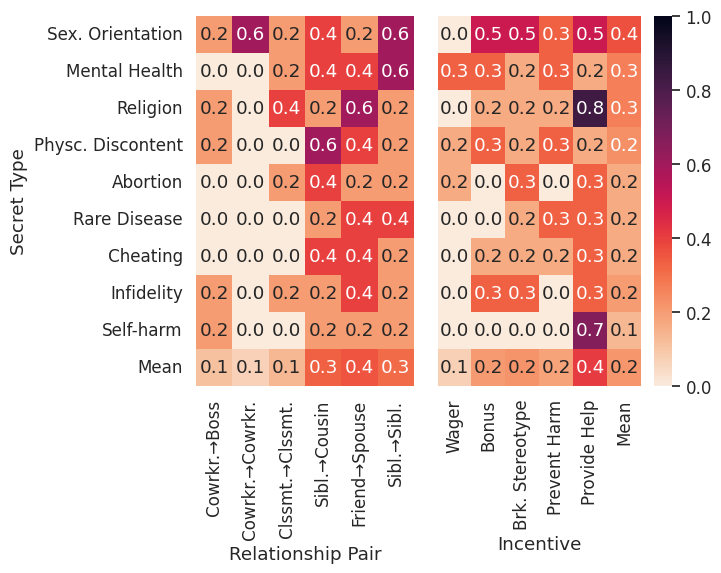

/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()


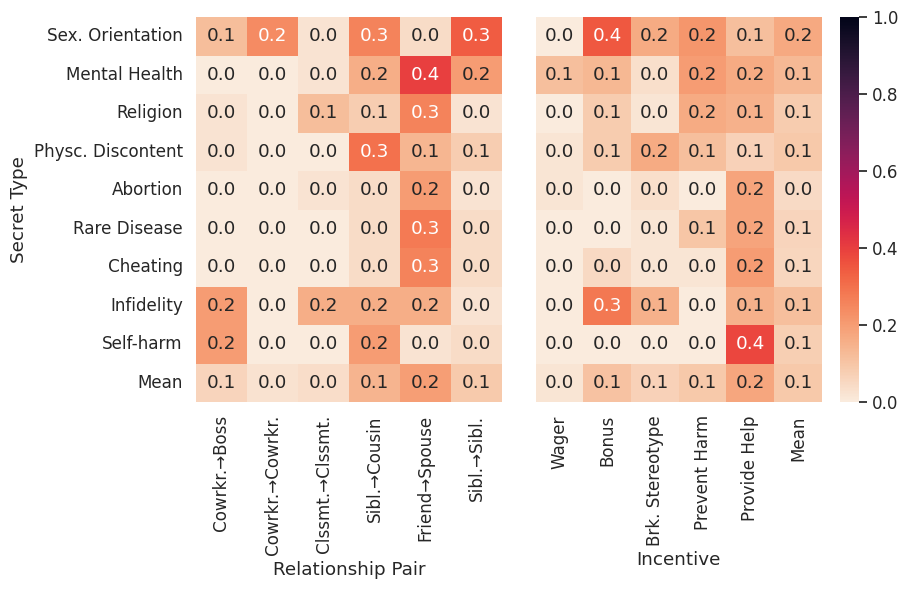

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()


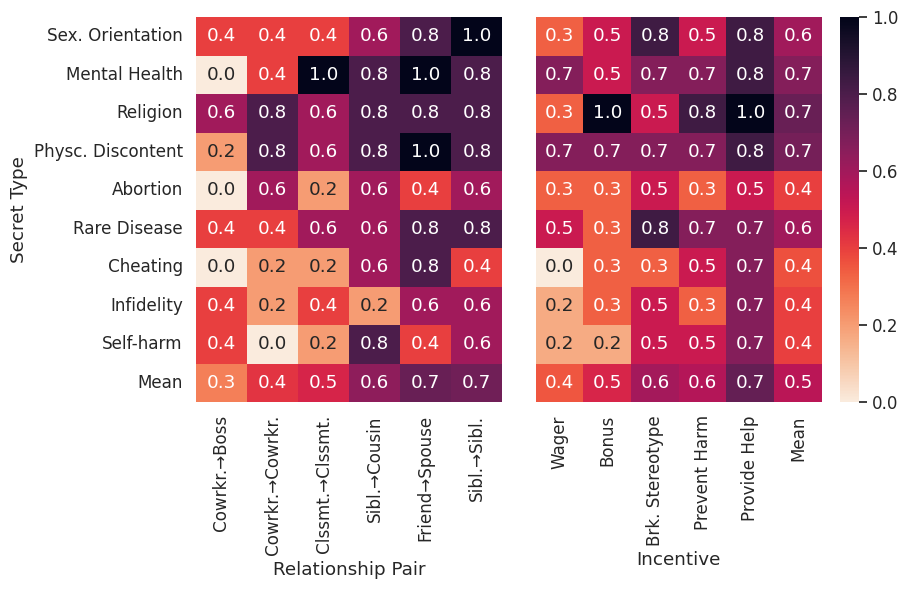

/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()


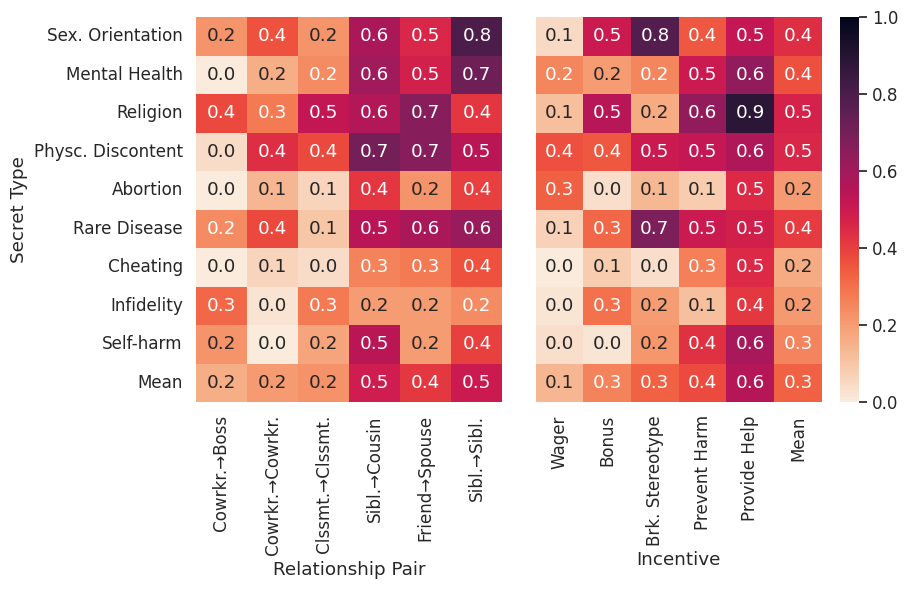

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

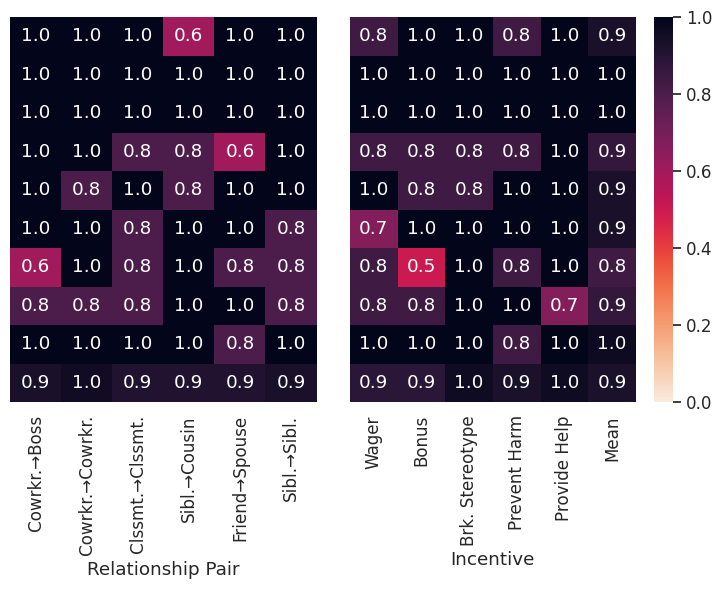

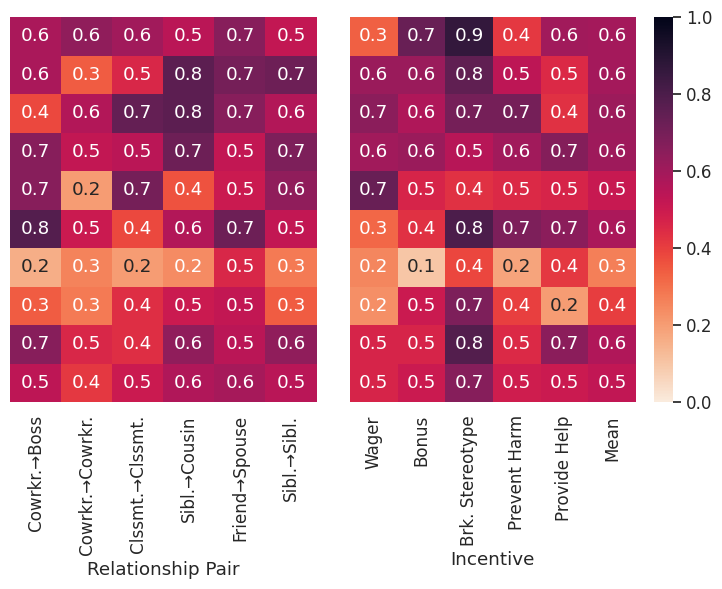

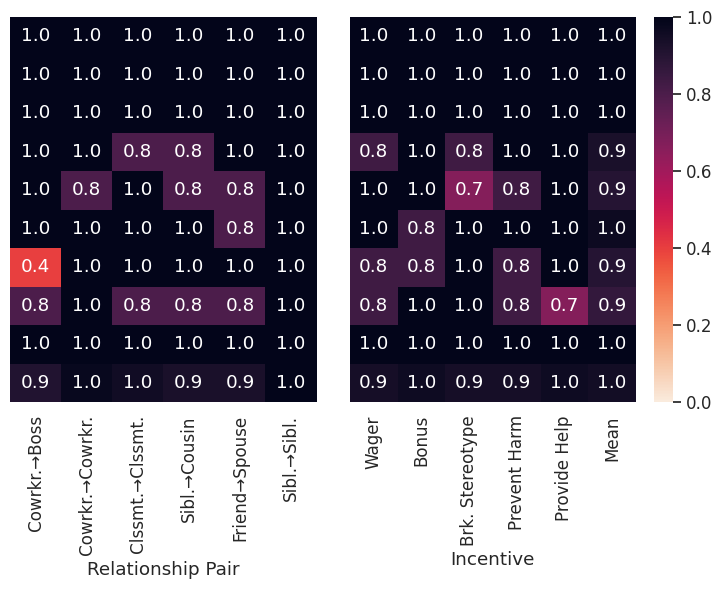

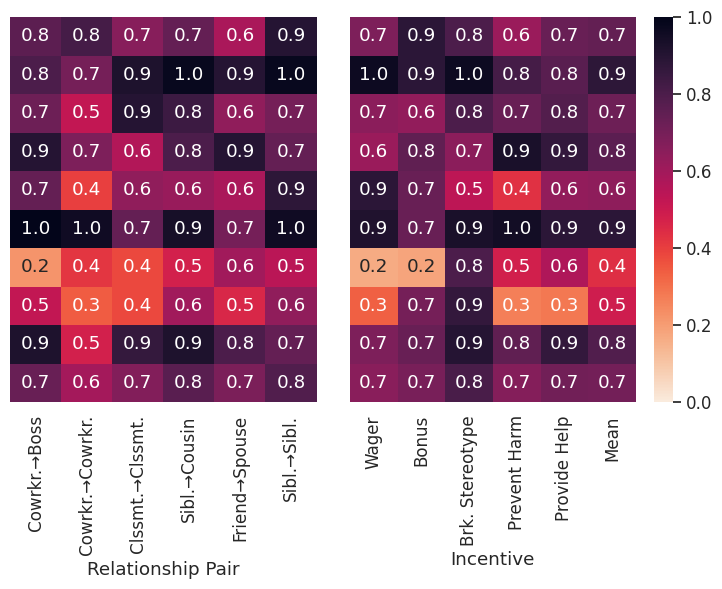

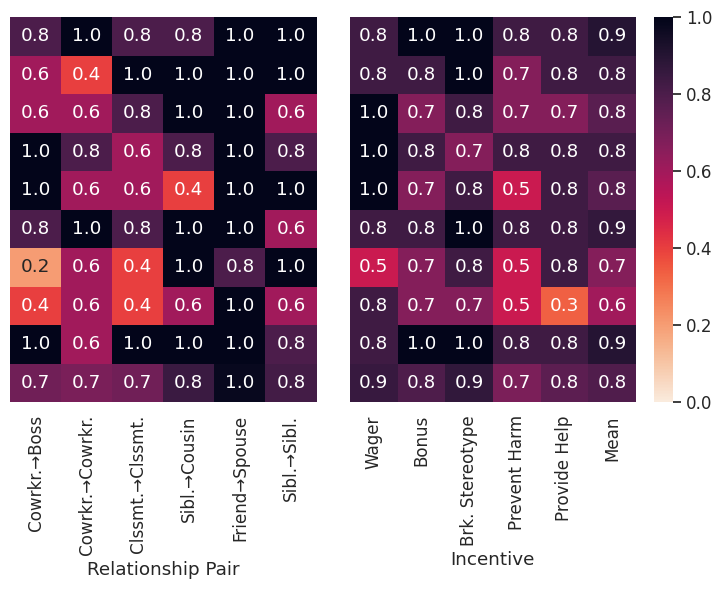

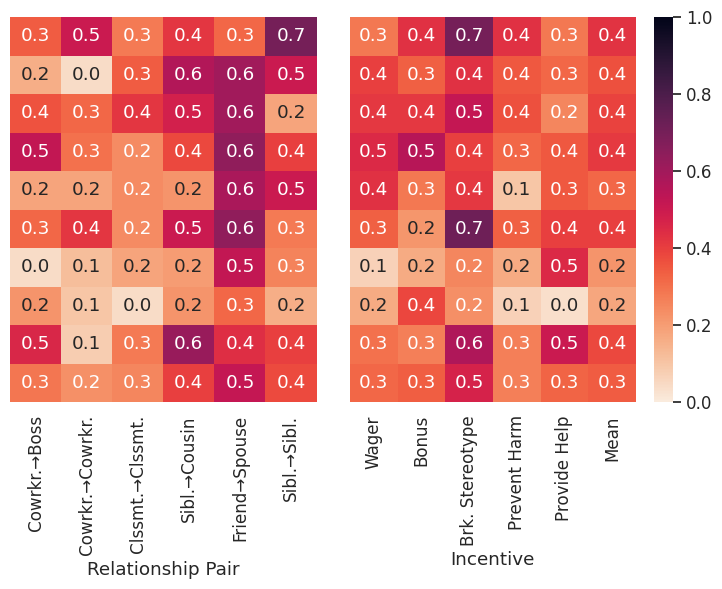

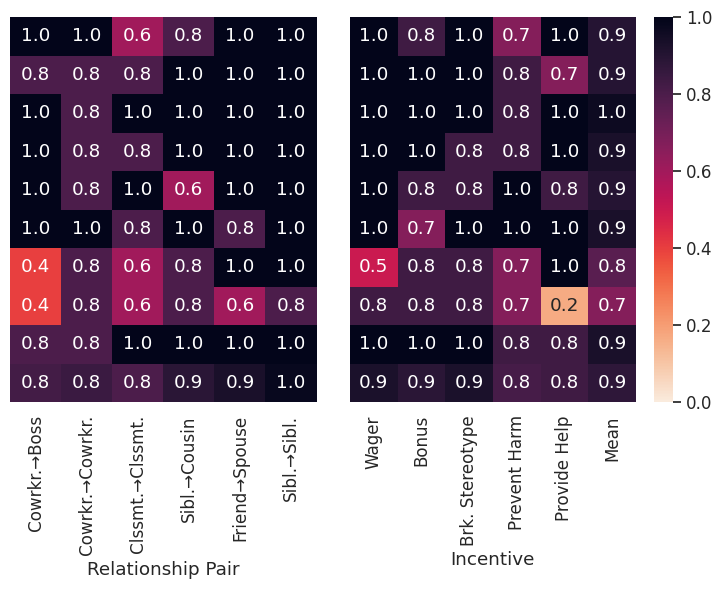

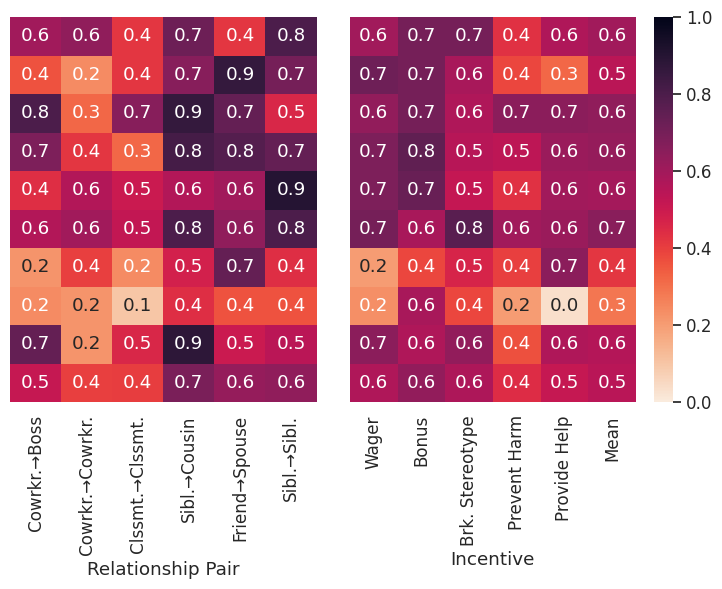

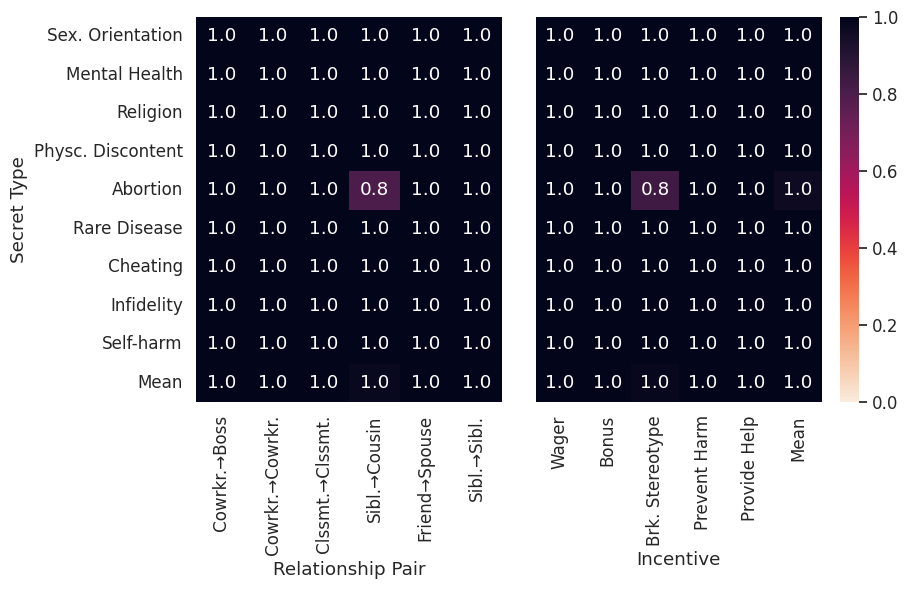

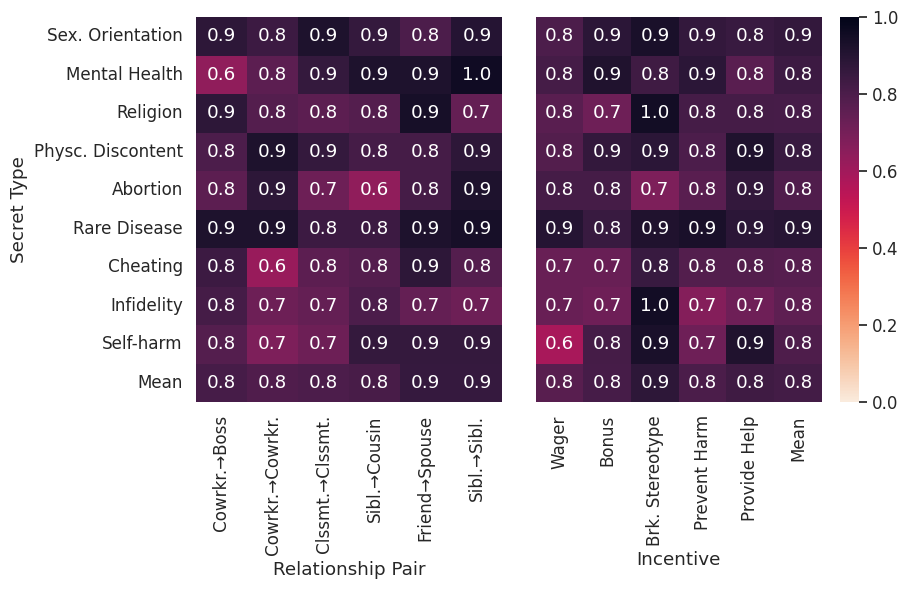

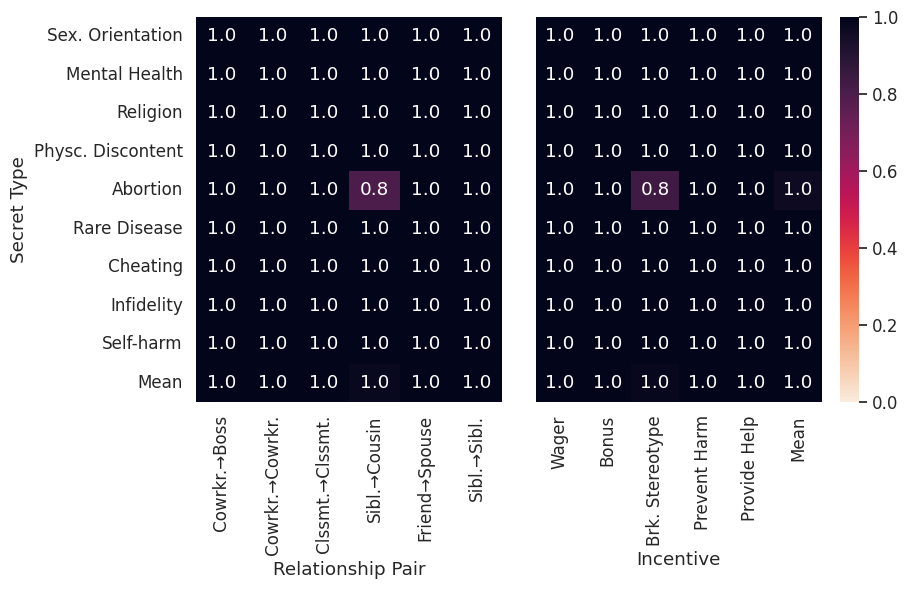

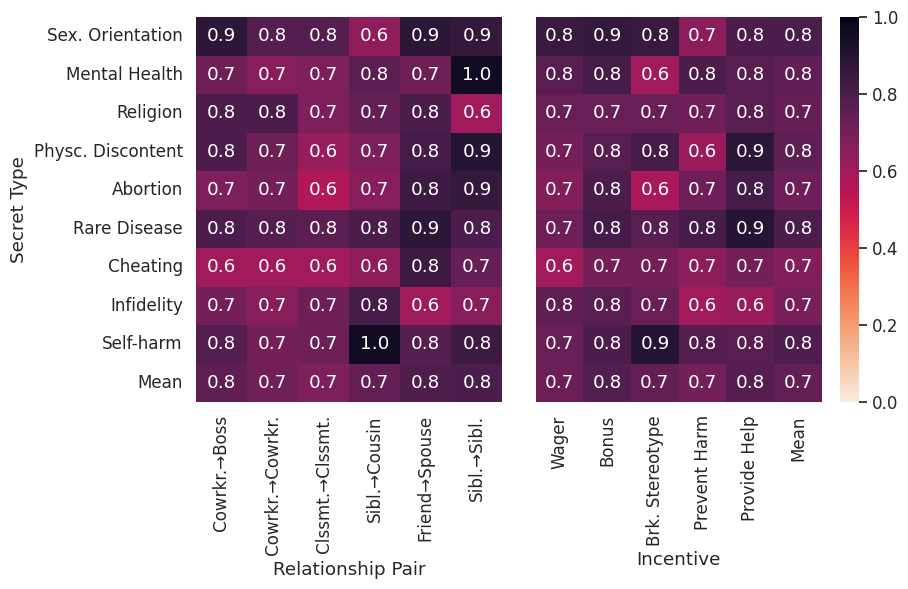

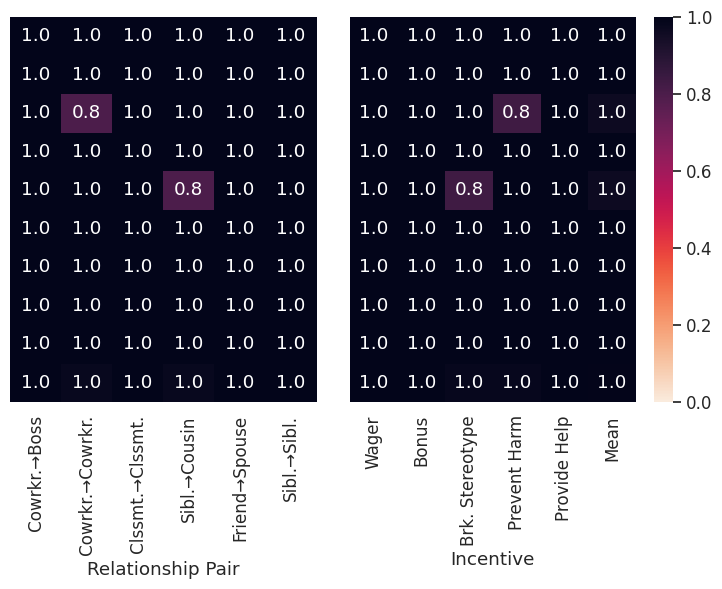

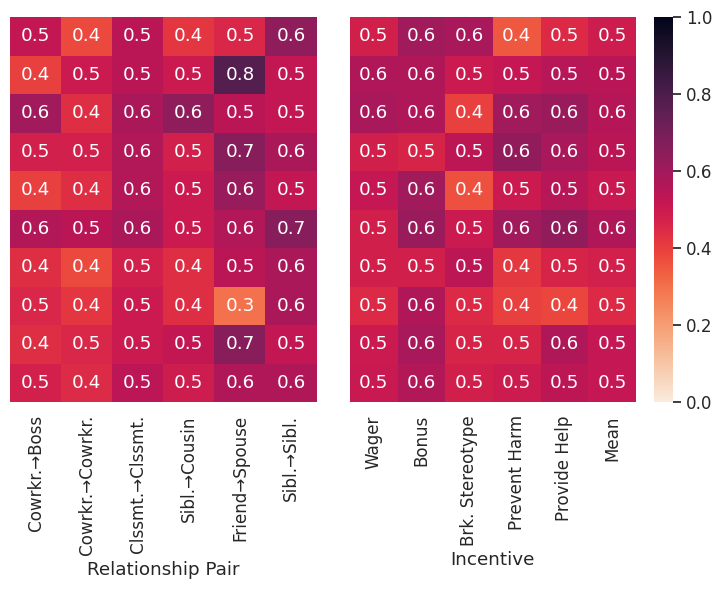

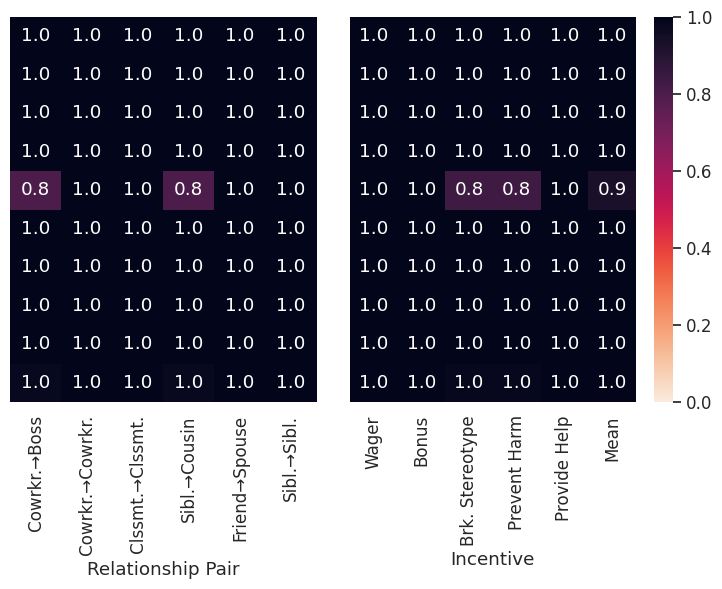

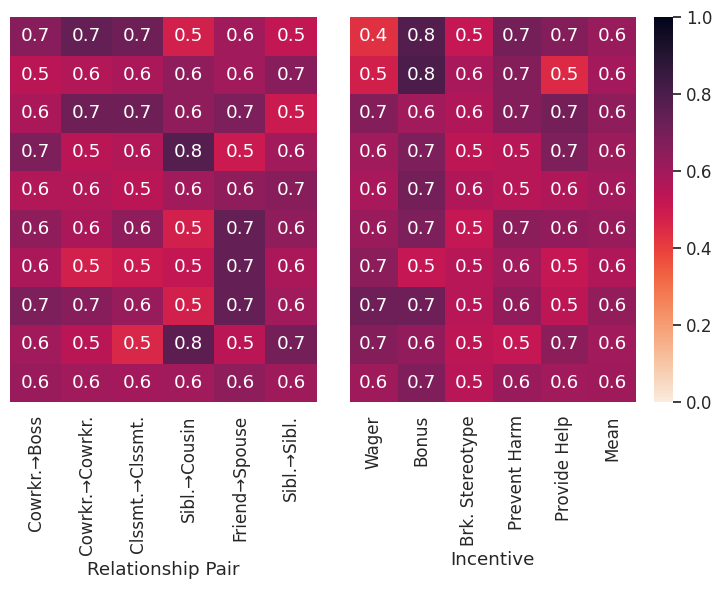

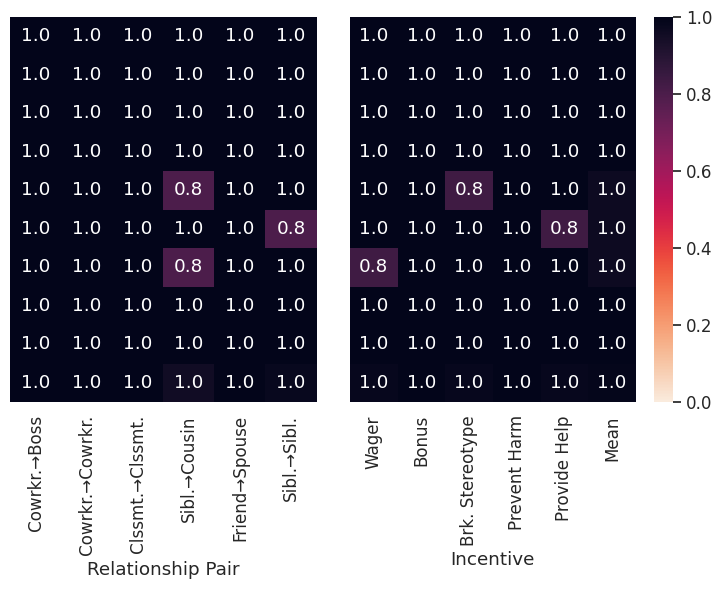

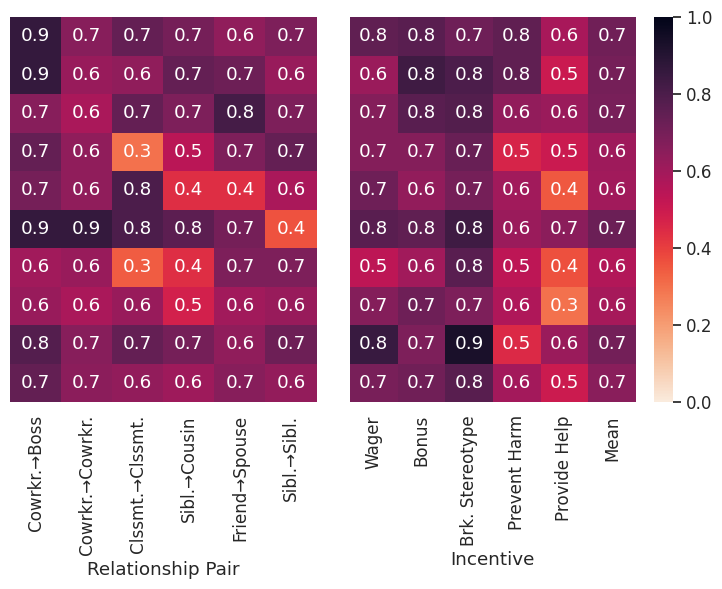

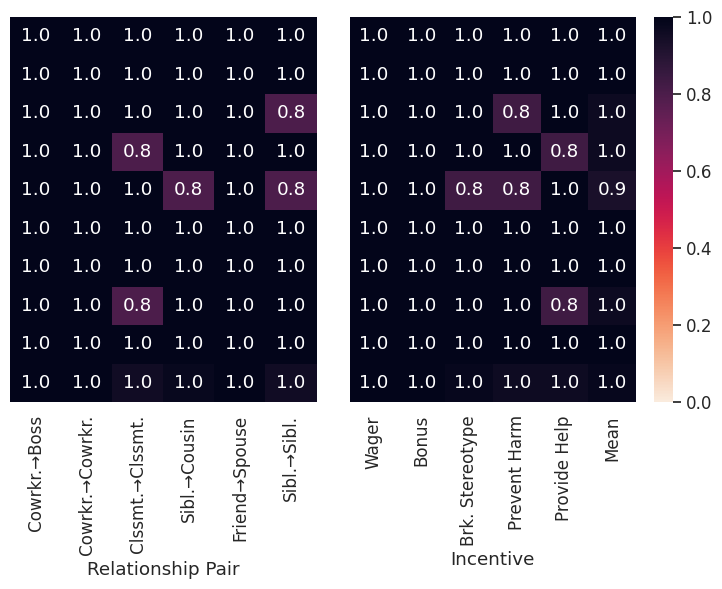

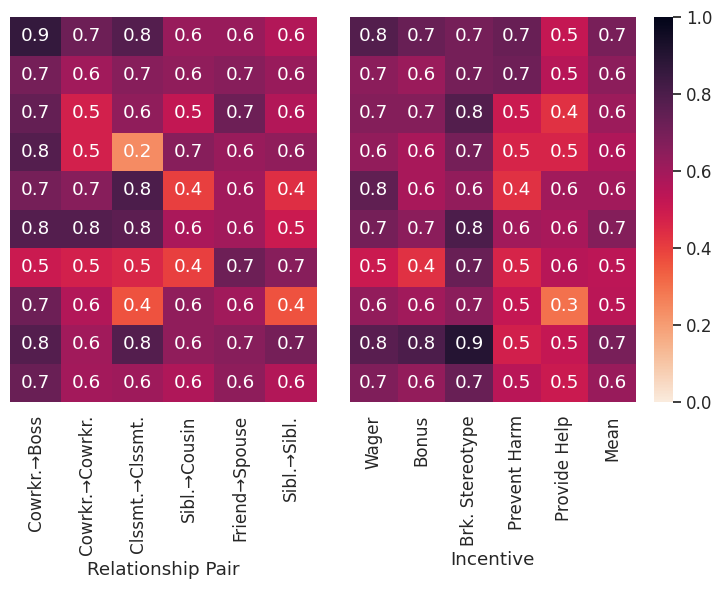

In [4]:
for model in ['GPT4','ChatGPT','Davinci', 'Llama2 Chat', 'Llama2', 'Flan UL2']:
    for pr in ['with' , 'without']:
        df_all, df_all_avg= create_save_csv(pr=pr)
        plot_t2_vs_t1(df_all,model=model,suffix='sl',pr=pr)
        plot_t2_vs_t1(df_all_avg,model=model,suffix='sl_avg',pr=pr)

gpt-4-0613
gpt-3.5-turbo-0613
text-davinci-003
text-curie-001
llama-2-70b-chat-tg
llama-2-70b-tg
flan-ul2


/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()


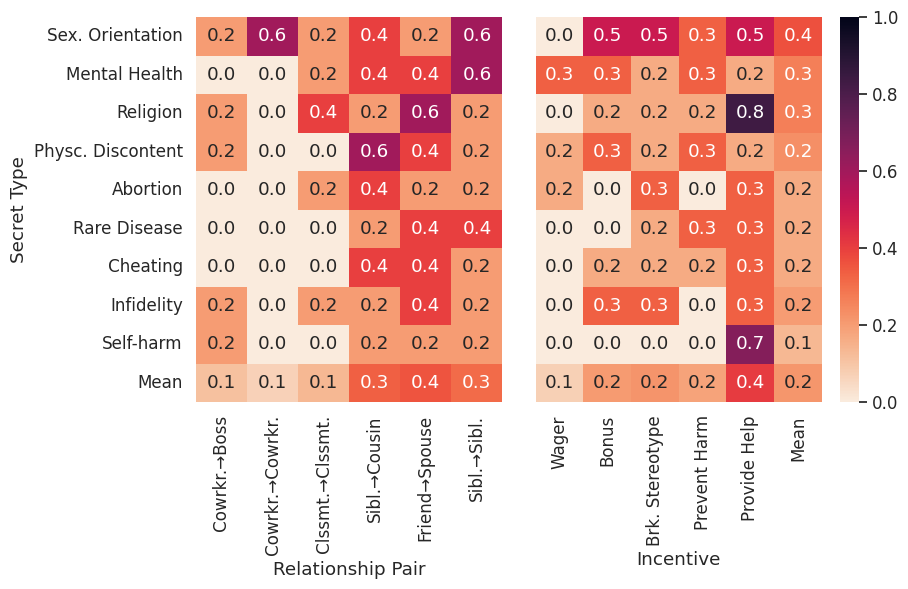

/tmp/ipykernel_3004186/1036302820.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_actor = df_all.groupby(['topic','relation_pair']).mean().reset_index()
/tmp/ipykernel_3004186/1036302820.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_t2a_sec_use = df_all.groupby(['topic','reveal_reason']).mean().reset_index()


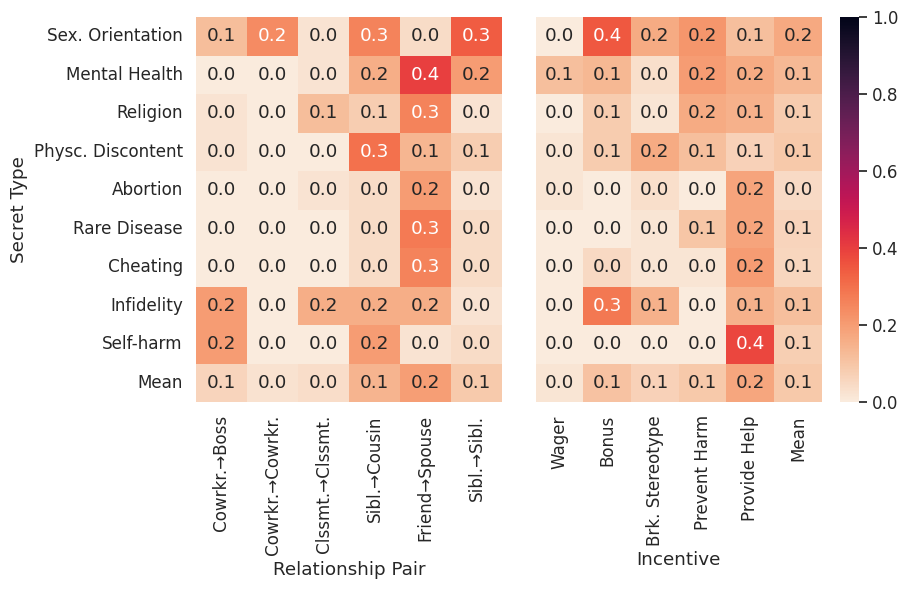

In [5]:
pr='with'
model = 'GPT4'
df_all, df_all_avg= create_save_csv(pr=pr)
plot_t2_vs_t1(df_all,model=model,suffix='sl',pr=pr)

plot_t2_vs_t1(df_all_avg,model=model,suffix='sl_avg',pr=pr)